In [1]:
# Check GPU status
!nvidia-smi

Tue Aug 20 22:18:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P400                    Off | 00000000:2D:00.0 Off |                  N/A |
| 34%   35C    P8              N/A /  N/A |    112MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

2024-08-20 22:19:09.787193: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 22:19:09.835384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 22:19:10.525918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [4]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Load graph
view=5
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/mayank/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [7]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1590078  Test:454306  Validation: 227152


In [16]:
# Model

model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=200,
    shuffle=True,
)

optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [17]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [18]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.6925
Epoch: 002, Loss: 0.6875
Epoch: 003, Loss: 0.6789
Epoch: 004, Loss: 0.6685
Epoch: 005, Loss: 0.6571
Epoch: 006, Loss: 0.6454
Epoch: 007, Loss: 0.6337
Epoch: 008, Loss: 0.6224
Epoch: 009, Loss: 0.6116
Epoch: 010, Loss: 0.6015
Epoch: 011, Loss: 0.5919
Epoch: 012, Loss: 0.5832
Epoch: 013, Loss: 0.5749
Epoch: 014, Loss: 0.5669
Epoch: 015, Loss: 0.5602
Epoch: 016, Loss: 0.5536
Epoch: 017, Loss: 0.5473
Epoch: 018, Loss: 0.5419
Epoch: 019, Loss: 0.5366
Epoch: 020, Loss: 0.5317
Epoch: 021, Loss: 0.5272
Epoch: 022, Loss: 0.5228
Epoch: 023, Loss: 0.5187
Epoch: 024, Loss: 0.5150


In [19]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.5114
Epoch: 002, Loss: 0.5082
Epoch: 003, Loss: 0.5051
Epoch: 004, Loss: 0.5018
Epoch: 005, Loss: 0.4992
Epoch: 006, Loss: 0.4963
Epoch: 007, Loss: 0.4939
Epoch: 008, Loss: 0.4912
Epoch: 009, Loss: 0.4889
Epoch: 010, Loss: 0.4866
Epoch: 011, Loss: 0.4841
Epoch: 012, Loss: 0.4820
Epoch: 013, Loss: 0.4801
Epoch: 014, Loss: 0.4782
Epoch: 015, Loss: 0.4764
Epoch: 016, Loss: 0.4742
Epoch: 017, Loss: 0.4728
Epoch: 018, Loss: 0.4706
Epoch: 019, Loss: 0.4695
Epoch: 020, Loss: 0.4676
Epoch: 021, Loss: 0.4661
Epoch: 022, Loss: 0.4646
Epoch: 023, Loss: 0.4628
Epoch: 024, Loss: 0.4613


In [20]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.4600
Epoch: 002, Loss: 0.4591
Epoch: 003, Loss: 0.4574
Epoch: 004, Loss: 0.4566
Epoch: 005, Loss: 0.4550
Epoch: 006, Loss: 0.4534
Epoch: 007, Loss: 0.4528
Epoch: 008, Loss: 0.4511
Epoch: 009, Loss: 0.4495
Epoch: 010, Loss: 0.4491
Epoch: 011, Loss: 0.4477
Epoch: 012, Loss: 0.4469
Epoch: 013, Loss: 0.4461
Epoch: 014, Loss: 0.4442
Epoch: 015, Loss: 0.4433
Epoch: 016, Loss: 0.4425
Epoch: 017, Loss: 0.4412
Epoch: 018, Loss: 0.4404
Epoch: 019, Loss: 0.4399
Epoch: 020, Loss: 0.4385
Epoch: 021, Loss: 0.4370
Epoch: 022, Loss: 0.4364
Epoch: 023, Loss: 0.4358
Epoch: 024, Loss: 0.4346


In [21]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.4337
Epoch: 002, Loss: 0.4322
Epoch: 003, Loss: 0.4324
Epoch: 004, Loss: 0.4319
Epoch: 005, Loss: 0.4302
Epoch: 006, Loss: 0.4299
Epoch: 007, Loss: 0.4293
Epoch: 008, Loss: 0.4278
Epoch: 009, Loss: 0.4267
Epoch: 010, Loss: 0.4257
Epoch: 011, Loss: 0.4259
Epoch: 012, Loss: 0.4246
Epoch: 013, Loss: 0.4246
Epoch: 014, Loss: 0.4227
Epoch: 015, Loss: 0.4222
Epoch: 016, Loss: 0.4212
Epoch: 017, Loss: 0.4211
Epoch: 018, Loss: 0.4205
Epoch: 019, Loss: 0.4199
Epoch: 020, Loss: 0.4184
Epoch: 021, Loss: 0.4180
Epoch: 022, Loss: 0.4170
Epoch: 023, Loss: 0.4168
Epoch: 024, Loss: 0.4156


In [22]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.4153
Epoch: 002, Loss: 0.4151
Epoch: 003, Loss: 0.4137
Epoch: 004, Loss: 0.4130
Epoch: 005, Loss: 0.4128
Epoch: 006, Loss: 0.4119
Epoch: 007, Loss: 0.4110
Epoch: 008, Loss: 0.4105
Epoch: 009, Loss: 0.4100
Epoch: 010, Loss: 0.4093
Epoch: 011, Loss: 0.4089
Epoch: 012, Loss: 0.4082
Epoch: 013, Loss: 0.4076
Epoch: 014, Loss: 0.4072
Epoch: 015, Loss: 0.4063
Epoch: 016, Loss: 0.4057
Epoch: 017, Loss: 0.4050
Epoch: 018, Loss: 0.4043
Epoch: 019, Loss: 0.4033
Epoch: 020, Loss: 0.4027
Epoch: 021, Loss: 0.4031
Epoch: 022, Loss: 0.4017
Epoch: 023, Loss: 0.4018
Epoch: 024, Loss: 0.4012


In [24]:
# Training
n_epochs=26

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.4005
Epoch: 002, Loss: 0.4008
Epoch: 003, Loss: 0.3996
Epoch: 004, Loss: 0.3982
Epoch: 005, Loss: 0.3984
Epoch: 006, Loss: 0.3976
Epoch: 007, Loss: 0.3976
Epoch: 008, Loss: 0.3962
Epoch: 009, Loss: 0.3963
Epoch: 010, Loss: 0.3954
Epoch: 011, Loss: 0.3951
Epoch: 012, Loss: 0.3941
Epoch: 013, Loss: 0.3944
Epoch: 014, Loss: 0.3932
Epoch: 015, Loss: 0.3932
Epoch: 016, Loss: 0.3921
Epoch: 017, Loss: 0.3920
Epoch: 018, Loss: 0.3915
Epoch: 019, Loss: 0.3906
Epoch: 020, Loss: 0.3906
Epoch: 021, Loss: 0.3904
Epoch: 022, Loss: 0.3893
Epoch: 023, Loss: 0.3894
Epoch: 024, Loss: 0.3886
Epoch: 025, Loss: 0.3873


100%|██████████| 795039/795039 [9:41:28<00:00, 22.79it/s]  


Epoch: 025, Val Mean Rank: 5379.88, Val MRR: 0.0325, Val Hits@10: 0.0539


In [25]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [26]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 125], [True, 31354]]


In [27]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 31354/31354 [22:53<00:00, 22.82it/s]

Test Mean Rank: 1968.25, Test MRR: 0.0597, Test Hits@10: 0.1584


In [28]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85299

In [29]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://www.ncbi.nlm.nih.gov/gene/1163>, Gene)",0.012890,0.061819,0.037308,-0.019249,0.022419,-0.020893,0.035755,-0.059820,0.037500,0.039202,...,-0.023240,-0.018909,0.030944,-0.022956,-0.041886,6.350719e-37,0.058970,0.005063,-0.058211,-6.348771e-37
"(<http://purl.obolibrary.org/obo/GO_1902115>, GO)",0.044673,0.031944,-0.043216,0.029803,-0.064706,0.063520,-0.056725,-0.030300,-0.043142,-0.040268,...,0.031130,0.064782,0.019130,0.064518,0.035378,6.569328e-37,0.032950,-0.028699,-0.032544,6.451884e-37
"(<http://purl.obolibrary.org/obo/MONDO_0009301>, Disease)",0.045572,0.034615,-0.048229,0.039428,-0.060906,0.061088,-0.047302,-0.030604,-0.048226,-0.044801,...,0.041342,0.061405,0.024231,0.060649,0.040277,4.946420e-37,0.034871,-0.038313,-0.034511,-6.000255e-37
"(<http://www.ncbi.nlm.nih.gov/gene/2692>, Gene)",0.015688,0.059819,0.030221,-0.018528,0.014346,-0.013199,0.026170,-0.055970,0.029957,0.032085,...,-0.021582,-0.012137,0.034666,-0.014549,-0.035508,-6.431812e-37,0.056086,0.007851,-0.055385,-6.658929e-37
"(<http://purl.obolibrary.org/obo/MONDO_0000535>, Disease)",0.014686,0.008609,-0.047773,0.027265,-0.043101,0.041034,-0.048822,-0.005946,-0.048157,-0.046802,...,0.030497,0.040396,-0.003572,0.043337,0.042588,-5.898185e-37,0.009002,-0.020791,-0.008746,-1.366766e-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/MONDO_0012718>, Disease)",0.047540,0.042103,-0.046991,0.047407,-0.065313,0.064484,-0.053042,-0.037421,-0.047299,-0.043598,...,0.048687,0.065592,0.021948,0.064905,0.038105,3.368561e-37,0.041405,-0.048021,-0.041018,-5.822904e-37
"(<https://www.mirbase.org/mature/MIMAT0002841>, miRNA)",-0.172683,-0.175699,-0.168164,-0.069570,0.158703,-0.168016,0.054155,0.180093,-0.174539,-0.188453,...,-0.047909,-0.164496,-0.164208,-0.155613,0.184732,6.074247e-37,-0.174887,0.110461,0.174114,6.377019e-37
"(<http://purl.obolibrary.org/obo/GO_0102175>, GO)",0.043632,0.038665,-0.045473,0.034608,-0.060442,0.060034,-0.051390,-0.036881,-0.045055,-0.042773,...,0.035817,0.060927,0.015515,0.060157,0.038727,6.778023e-37,0.040475,-0.034098,-0.040034,6.420482e-37
"(<http://purl.obolibrary.org/obo/HP_0500107>, Phenotype)",0.045701,0.040489,-0.049314,0.052068,-0.064389,0.064416,-0.051817,-0.036952,-0.049578,-0.046731,...,0.052557,0.064513,0.021831,0.064236,0.040187,-5.558157e-37,0.040955,-0.052452,-0.040626,-6.192275e-37


In [30]:
!ls -lh

total 668K
-rw-rw-r--  1 mayank mayank  42K ago 19 13:02 333.ipynb
drwxrwxr-x 11 mayank mayank 4,0K apr 29 21:15 curate-gpt
-rw-r--r--  1 mayank mayank 2,0K mar 12 16:27 hp-documentation-sbso.desktop
drwxrwxr-x 11 mayank mayank 4,0K apr  8 11:20 pyRDF2Vec
drwxrwxr-x  2 mayank mayank 4,0K apr  8 17:36 pyRDF2vec_cC
-rw-rw-r--  1 mayank mayank  25K ago 19 14:01 results_VIEW0_FirstOrderLINE.pkl
-rw-rw-r--  1 mayank mayank  12K ago 19 13:08 results_VIEW1_FirstOrderLINE.pkl
-rw-rw-r--  1 mayank mayank  12K ago 19 16:55 results_VIEW5_FirstOrderLINE.pkl
-rw-rw-r--  1 mayank mayank 401K ago 19 13:01 rnakg_link_prediction_VIEWS.ipynb
-rw-rw-r--  1 mayank mayank  407 lug 30 12:17 run_notebook.py
drwx------  3 mayank mayank 4,0K mar 12 16:40 snap
-rw-rw-r--  1 mayank mayank 2,6K mag  7 14:24 Untitled-1.ipynb
drwxrwxr-x  3 mayank mayank 4,0K lug 30 12:22 VIEW0
-rw-rw-r--  1 mayank mayank  58K ago 14 22:09 view0_complex_RNAKG.ipynb
-rw-rw-r--  1 mayank mayank  16K lug 30 12:05 view0_complex_RNAKG.py

In [31]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [32]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

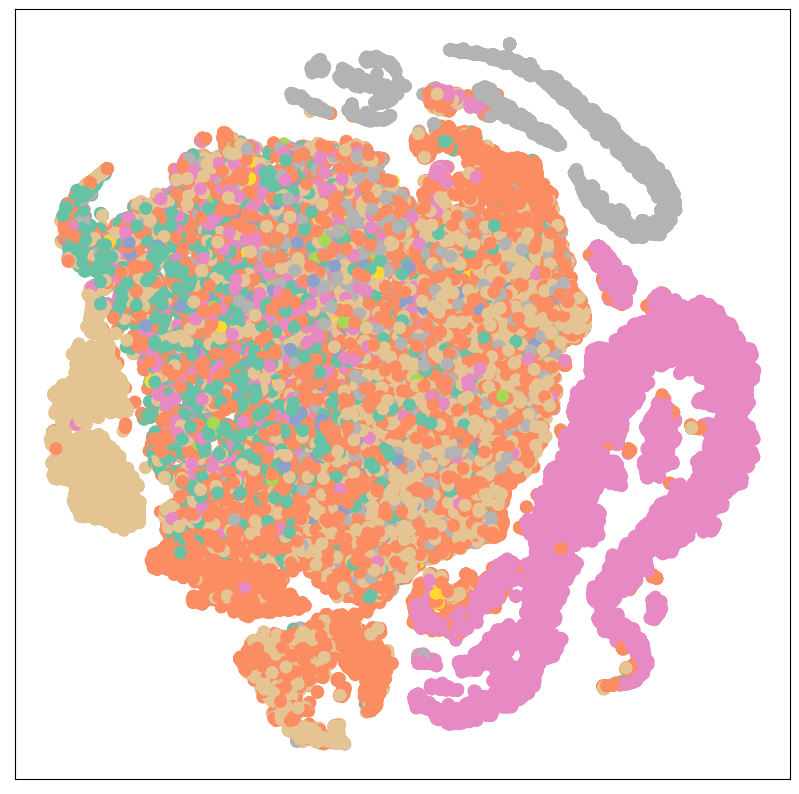

In [33]:
visualize(node_embedding,node_types)

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embedding.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [36]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6290
Precision: 0.5903
Recall: 0.6290


/home/mayank/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [38]:
node_embedding.values

array([[ 1.2890187e-02,  6.1818864e-02,  3.7308183e-02, ...,
         5.0632651e-03, -5.8211219e-02, -6.3487708e-37],
       [ 4.4672683e-02,  3.1944323e-02, -4.3216195e-02, ...,
        -2.8699126e-02, -3.2544024e-02,  6.4518839e-37],
       [ 4.5572240e-02,  3.4615044e-02, -4.8228562e-02, ...,
        -3.8312774e-02, -3.4510951e-02, -6.0002551e-37],
       ...,
       [ 4.3631963e-02,  3.8664546e-02, -4.5472845e-02, ...,
        -3.4098148e-02, -4.0033650e-02,  6.4204819e-37],
       [ 4.5701053e-02,  4.0489264e-02, -4.9313974e-02, ...,
        -5.2452076e-02, -4.0625941e-02, -6.1922751e-37],
       [ 3.9498802e-02,  4.8763826e-02, -3.3915915e-02, ...,
        -5.1149238e-02, -4.8897162e-02,  1.3090370e-38]], dtype=float32)

In [54]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [60]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embedding.index = [name[0] for name in node_embedding.index]

In [61]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embedding.values,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW5_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/222 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/56 [00:00<?, ?it/s]

In [68]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINE.csv"
results.to_csv(filename)

In [63]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,f1_score,precision,false_discovery_rate,false_omission_rate,accuracy,negative_predictive_value,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800000,1.0,True,0.539762,0.719745,0.280255,0.631288,0.509106,0.368712,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800000,1.0,True,0.565005,0.732054,0.267946,0.619520,0.527768,0.380480,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800000,1.0,True,0.540000,0.719707,0.280293,0.631267,0.509214,0.368733,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800000,1.0,True,0.563381,0.732117,0.267883,0.619863,0.526886,0.380137,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800000,1.0,True,0.539863,0.720256,0.279744,0.630997,0.509367,0.369003,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800000,1.0,True,0.564832,0.732463,0.267537,0.619339,0.527837,0.380661,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800000,1.0,True,0.539566,0.719893,0.280107,0.631243,0.509064,0.368757,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800000,1.0,True,0.565523,0.733203,0.266797,0.618779,0.528524,0.381221,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800000,1.0,True,0.540021,0.720552,0.279448,0.630811,0.509570,0.369189,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800000,1.0,True,0.565124,0.732820,0.267180,0.619080,0.528144,0.380920,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


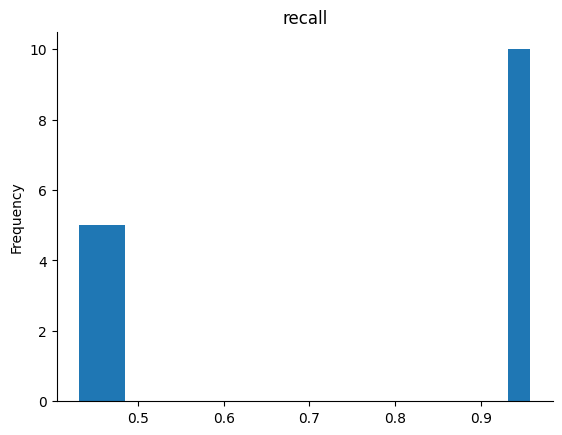

In [59]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)